### Big picture - Iris flower dataset training pipeline

+ Load iris flower dataset into train/test set using a feature vies
+ Train mode with SVM
+ Evaluate model performande using test set
+ Register model with Hopsworks model registry

In [ ]:
# !pip install -U hopsworks --quiet

In [1]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
import hopsworks

### Get feature view

+ Login to hopsworks
+ Get feature view for iris flower dataset / create on if it does not already exist
+ Nb: If this is the first time running, the featue view will be created (it ocntain all of the columns in our feature group)
+ There are 5 columns in the datset: 4 of them are features and the 'species' is the label (i.e what we are trying to predict)

In [2]:
# Login to hopsworks
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/70809
Connected. Call `.close()` to terminate connection gracefully.


In [15]:
# Get the feature view or create it if it does not exist
try: 
    feature_view = fs.get_feature_view(name="sklearn_iris_dataset", version=1)
except:
    # Get our already created feature group
    iris_fg = fs.get_feature_group(name="sklearn_iris_dataset", version=1)
    # Get all the features from that feature group
    query = iris_fg.select_all()
    # Create feature view
    feature_view = fs.create_feature_view(name="sklearn_iris_dataset",
                                      version=1,
                                      description="Read from the Iris flower dataset from sklearn datasets",
                                      labels=["species"],
                                      query=query)

### Split into training and test set

+ We'll split our data into train and test set.
+ This is because we want to train and evaluate the model that will be registered in teh model registry.

In [16]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using Hive (2.25s) 


In [19]:
X_train.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.7,3.8,1.7,0.3
1,5.6,2.7,4.2,1.3
2,6.3,3.3,6.0,2.5
3,6.0,2.9,4.5,1.5
4,5.0,3.0,1.6,0.2


In [20]:
y_train.head()

,species
0,setosa
1,versicolor
2,virginica
3,versicolor
4,setosa


In [21]:
X_test.head()

,sepal_length,sepal_width,petal_length,petal_width
7,6.3,3.3,4.7,1.6
15,6.4,2.8,5.6,2.2
18,5.9,3.0,4.2,1.5
22,5.1,3.8,1.9,0.4
24,6.3,2.3,4.4,1.3


In [22]:
y_test.head()

,species
7,versicolor
15,virginica
18,versicolor
22,setosa
24,versicolor


### Preprocessing pipeline

In [23]:
# convert the labels to number
def labels_to_num(df):
    df = df.copy()

    target = {
        "setosa": 0,
        "versicolor": 1,
        "virginica": 2
    }

    df["species"] = df['species'].map(target) 
    
    return df

In [24]:
y_train = labels_to_num(y_train)
y_test = labels_to_num(y_test)

In [25]:
y_train.head()

,species
0,0
1,1
2,2
3,1
4,0


In [26]:
y_test.head()

,species
7,1
15,2
18,1
22,0
24,1


### Training pipline

Train the model

In [27]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [30]:
model = make_pipeline(
    StandardScaler(),
    SVC(C=0.1, coef0=5, degree=2,
        gamma="scale", kernel='poly', 
        random_state=42, decision_function_shape='ovo',
        probability=True))

model.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=0.1, coef0=5, decision_function_shape='ovo', degree=2,
                     kernel='poly', probability=True, random_state=42))])

Now, we have trained our model. We can evaluate our model on the **test_set** to estimate its performance.

In [31]:
y_pred = model.predict(X_test)
y_pred

array([1, 2, 1, 0, 1, 2, 0, 0, 0, 2, 1, 1, 0, 2, 1, 1, 1, 0, 0, 2, 0, 0,
       1, 2, 0, 0, 2, 1, 0, 1])

In [ ]:
# Get the accuracy

In [32]:
from sklearn.metrics import classification_report

In [33]:
metrics = classification_report(y_test, y_pred, output_dict=True)
metrics_n = classification_report(y_test, y_pred)
print(metrics_n)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.91      1.00      0.95        10
           2       1.00      0.88      0.93         8

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.96        30
weighted avg       0.97      0.97      0.97        30



In [36]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [41]:
from sklearn.metrics import confusion_matrix

results = confusion_matrix(y_test, y_pred)
print(results)

[[12  0  0]
 [ 0 10  0]
 [ 0  1  7]]


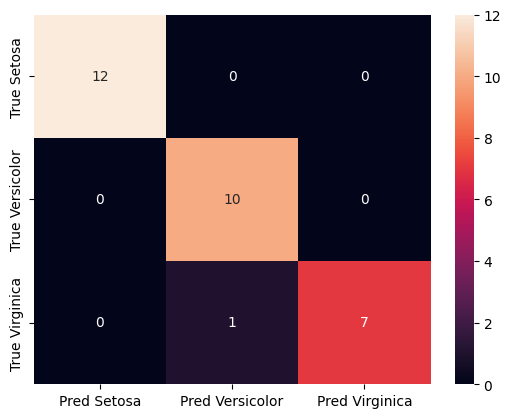

In [45]:
from matplotlib import pyplot

df_cm = pd.DataFrame(results, ['True Setosa', 'True Versicolor', 'True Virginica'],
                     ['Pred Setosa', 'Pred Versicolor', 'Pred Virginica'])

cm = sns.heatmap(df_cm, annot=True)

fig = cm.get_figure()
# save the model to a file
fig.savefig("assets/confusion_matrix.png") 
fig.show()

## Register the Model with Hopsworks Model Registry



In [46]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import os
import joblib
import hopsworks
import shutil

In [47]:
# Connect to model registry api
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


In [48]:
# create a folder, Pickle the model, add the modelto that folder and add the confusion matrix image as well

# The 'iris_model' directory will be saved to the model registry
model_dir="iris_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)
joblib.dump(model, model_dir + "/iris_model.pkl")
# add the confusion matrix to the folder
shutil.copyfile("assets/confusion_matrix.png", model_dir + "/confusion_matrix.png")

'iris_model/confusion_matrix.png'

In [51]:
# What is this
input_example = X_train.sample()
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

In [52]:
# Create model registry
iris_model = mr.python.create_model(
    version=1,
    name="sklearn_iris", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    input_example=input_example, 
    description="sklearn Iris Flower Predictor")

iris_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/18396 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/5410 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/20 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/479 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/70809/models/sklearn_iris/1


Model(name: 'sklearn_iris', version: 1)